<a href="https://colab.research.google.com/github/jiaminho/Pedestrian-Trajectory-Prediction-LSTM/blob/main/Ho_JiaMin_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CITS5017 Deep Learning Project 1

Jia Min Ho (23337561)

Version control: https://github.com/jiaminho/Pedestrian-Trajectory-Prediction-LSTM


In this project, we explore a pedestrian trajectory dataset derived from the widely recognized ETH/UCY dataset. Utilizing the Zara scene, pedestrian trajectories are captured in 2D coordinates from overhead camera videos. These trajectories have been standardized to lie within a [-1, +1] range for both x and y coordinates and are 20 frames (or timesteps) in length. The project's core tasks involve training two LSTM models for predicting pedestrian trajectories and a Variational Autoencoder (VAE) for generating new trajectories.

**Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional, Concatenate

**Load data file**

In [ ]:
def load_data(filename):
  with open(filename, "rb") as f:
    train = np.load(f)
    val = np.load(f)
  return train, val

train_set, val_set = load_data("zara1.npy")

In [ ]:
# checking train_set shape
train_set.shape

(26507, 20, 2)

train set is a 3D tensor of the shape (26507, 20, 2)

In [ ]:
# checking val_set shape
val_set.shape

(2315, 20, 2)

val set is a 3D tensor of the shape (2315, 20, 2)

In [ ]:
# checking data
train_set[:1]

array([[[-0.31367778,  0.06750966],
        [-0.29939284,  0.04183492],
        [-0.28788528,  0.02332389],
        [-0.27795722,  0.00511593],
        [-0.27771266, -0.01810555],
        [-0.27427557, -0.0401845 ],
        [-0.26811742, -0.06929811],
        [-0.26960516, -0.09556106],
        [-0.2664506 , -0.12253553],
        [-0.25403196, -0.15084949],
        [-0.2478035 , -0.17821016],
        [-0.24339741, -0.21024651],
        [-0.23582799, -0.24103601],
        [-0.22989552, -0.27321961],
        [-0.22685222, -0.30169945],
        [-0.21930551, -0.33237906],
        [-0.21320741, -0.36119077],
        [-0.21341177, -0.39253789],
        [-0.20912005, -0.42605787],
        [-0.20061589, -0.4666159 ]]])

Each trajectory in each frame is a 2D point (x,y).

In [ ]:
# Set random seeds for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## 1. Split Trajectories into Observed and Future

Split the trajectories into two parts: the observed part containing the trajectory coordinates for
the first 12 frames; the future part containing the trajectory coordinates for the remaining 8
frames.

In [ ]:
def split_trajectories(data, observed_len, future_len):
    # Variable length for observed and future parts
    observed = data[:, :observed_len, :]
    future = data[:, observed_len:observed_len + future_len, :]
    return observed, future

train_observed, train_future = split_trajectories(train_set, 12, 8)
val_observed, val_future = split_trajectories(val_set, 12, 8)

## 2. Plot Sampled Trajectories

In [ ]:
# Reusable function for displaying 30 random trajectories in subplots
def display_sampled_trajectories(observed, true_future, predicted_future=None, generated=None, title="Sampled Trajectories", seed=42, connect=True, show_legend=[True, True, True]):
    np.random.seed(seed)  # For reproducibility
    indices = np.random.choice(observed.shape[0], 30, replace=False)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    for i, ax in enumerate(axs):
        for j in range(10):
            index = indices[i*10 + j]
            ax.plot(observed[index, :, 0], observed[index, :, 1], color='blue', marker='.', label='Observed' if j==0 else "")
            ax.plot(true_future[index, :, 0], true_future[index, :, 1], color='red', marker='.', label='True Future' if j==0 else "")

            # Connect the end of observed to the start of true_future, if connect is True
            if connect:
                ax.plot([observed[index, -1, 0], true_future[index, 0, 0]],
                        [observed[index, -1, 1], true_future[index, 0, 1]], color='red')

            # Check if predicted_future is provided
            if predicted_future is not None:
                ax.plot(predicted_future[index, :, 0], predicted_future[index, :, 1], color='green', marker='.', label='Predicted Future' if j==0 else "")

                # Connect the end of observed to the start of predicted_future, if connect is True
                if connect:
                    ax.plot([observed[index, -1, 0], predicted_future[index, 0, 0]],
                            [observed[index, -1, 1], predicted_future[index, 0, 1]], color='green')

        if show_legend[i]:
            ax.legend(loc='best')

        ax.axis('equal')
        ax.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


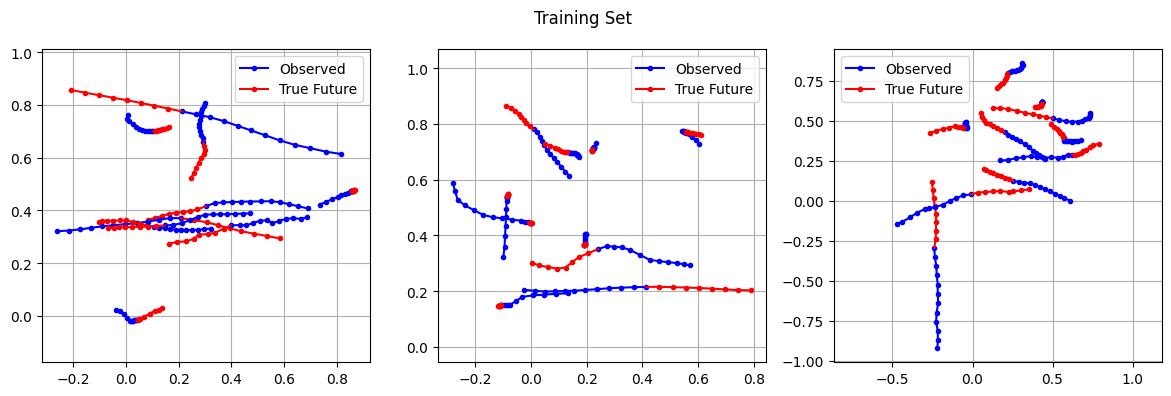

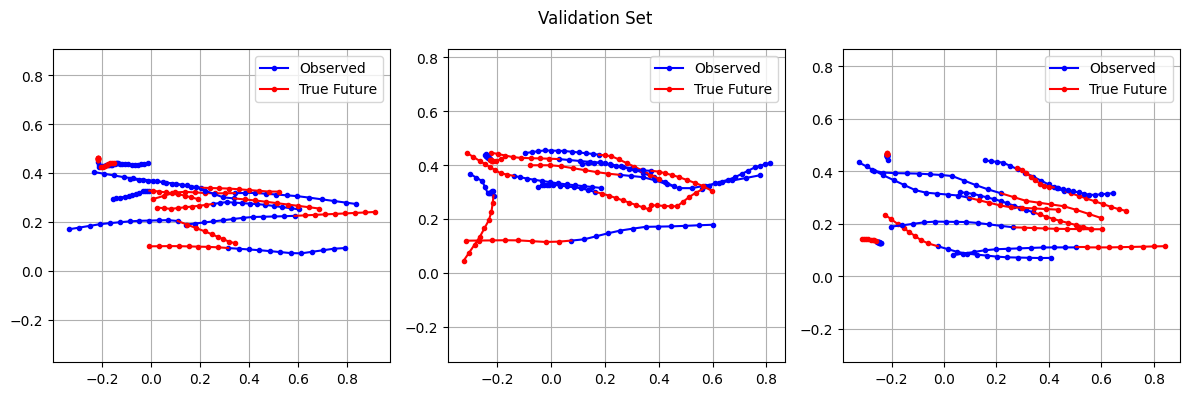

In [ ]:
# Call the function for training set
display_sampled_trajectories(train_observed, train_future, title="Training Set")

# Call the function for validation set
display_sampled_trajectories(val_observed, val_future, title="Validation Set")

## 3. First LSTM Model

The first LSTM model predicts just one step into the future. This is a relatively simpler architecture where the LSTM is trained to map a sequence of observed trajectories to the next immediate trajectory point. After training, to predict multiple future steps, we use a for-loop to repeatedly input the predictions back into the LSTM.

**ADE** and **FDE** loss function:

In [ ]:
def ADE(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))

def FDE(y_true_last_step, y_pred_last_step):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_last_step - y_pred_last_step), axis=-1)))

Custom callback to print every 10th epoch

In [ ]:
# Print every 10th epoch
class PrintEvery10Epochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: val_loss = {logs['val_loss']}, loss = {logs['loss']}")

**First LSTM model**

In [ ]:
# Design the LSTM
simple_model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(None, 2)),
    LSTM(16),
    Dense(2)  # To predict the x,y coordinates for the next timestep
])

# Compile the model
simple_model.compile(optimizer='adam', loss=ADE)

# Early stopping callback
early_stop_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Add custom callback to the list
callbacks_list=[PrintEvery10Epochs(), early_stop_val_loss]

# Train the model
history_simple_model = simple_model.fit(train_observed, train_future[:, 0, :],
                                        validation_data=(val_observed, val_future[:, 0, :]),
                                        epochs=100, callbacks=callbacks_list, batch_size=32, verbose=0)

Epoch 0: val_loss = 0.016616810113191605, loss = 0.06684212386608124
Epoch 10: val_loss = 0.002916495781391859, loss = 0.005211221519857645
Epoch 20: val_loss = 0.0038645383901894093, loss = 0.0044065602123737335


In [ ]:
 # Show the architecture
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4480      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
Total params: 7650 (29.88 KB)
Trainable params: 7650 (29.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This is a simple LSTM neural network designed for sequence-to-point prediction. It has two LSTM layers followed by a Dense layer. The first LSTM has 32 units and returns full sequences, while the second has 16 units. The Dense layer has 2 units to predict x and y coordinates for the next time step. The model uses the Adam optimizer and a custom loss function (ADE). It's trained with early stopping based on validation loss and includes a custom callback for logging. The model has 7,650 trainable parameters and is trained with a batch size of 32. It's designed to stop if the validation loss doesn't improve for 10 consecutive epochs.

**Learning Curves**

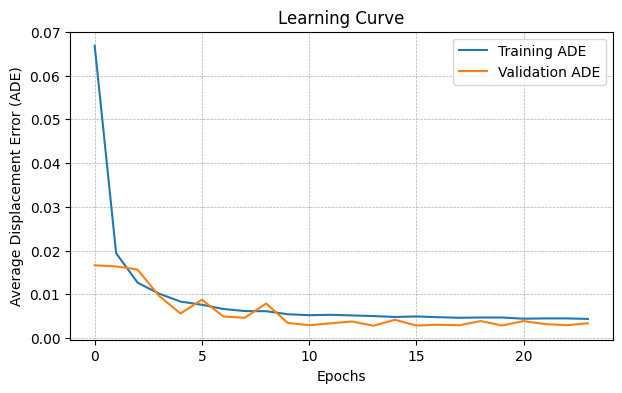

In [ ]:
def plot_learning_curves(history):
    plt.figure(figsize=(7, 4))

    # Plotting loss curves
    plt.plot(history.history['loss'], label='Training ADE')
    plt.plot(history.history['val_loss'], label='Validation ADE')

    # Adding gridlines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Average Displacement Error (ADE)')
    plt.title('Learning Curve')

    plt.show()

plot_learning_curves(history_simple_model)

The learning curve depicts the model's performance over 35 epochs using Average Displacement Error (ADE) for both training and validation sets. Initially, there's a rapid decrease in errors, showing quick learning. By around epoch 10, both curves stabilize, indicating minimal performance improvement thereafter. Throughout, there's a small consistent gap, with the training ADE slightly higher than the validation. The model has learned effectively without significant overfitting, as shown by the closeness of the two curves.

**Predict Remaining Frames**

In [ ]:
def predict_future_trajectory(observed, model, future_len):
    predicted_future = np.zeros((observed.shape[0], future_len, 2))  # Initialize predicted_future array
    current_input = observed  # Initialize the input with the observed data

    for i in range(future_len):
        next_step = model.predict(current_input, verbose=0)  # Model prediction for the next step

        predicted_future[:, i, :] = next_step  # Store the prediction

        # Prepare the input for the next prediction
        current_input = np.concatenate([current_input[:, 1:, :], next_step[:, np.newaxis, :]], axis=1)

    return predicted_future

# Get the predicted future trajectory for the validation set
predicted_val_future = predict_future_trajectory(val_observed, simple_model, 8)

**Calculate Average Displacement Error (ADE) and Final Displacement Error (FDE)**



In [ ]:
# ADE & FDE using the predictions generated by the simple model
ade_simple = ADE(val_future, predicted_val_future)
fde_simple = FDE(val_future[:, -1, :], predicted_val_future[:, -1, :])
print(f"LSTM 1 - Average Displacement Error (ADE): {ade_simple:.4f}")
print(f"LSTM 1 - Final Displacement Error (FDE): {fde_simple:.4f}")

LSTM 1 - Average Displacement Error (ADE): 0.0392
LSTM 1 - Final Displacement Error (FDE): 0.0898


The Average Displacement Error (ADE) is 0.0392, indicating the average prediction error across all time steps. The Final Displacement Error (FDE) is 0.0898, representing the error for the model's last prediction in the sequence, which is higher than the average error.

**Plot Errors (ADE and FDE) vs Time Step**

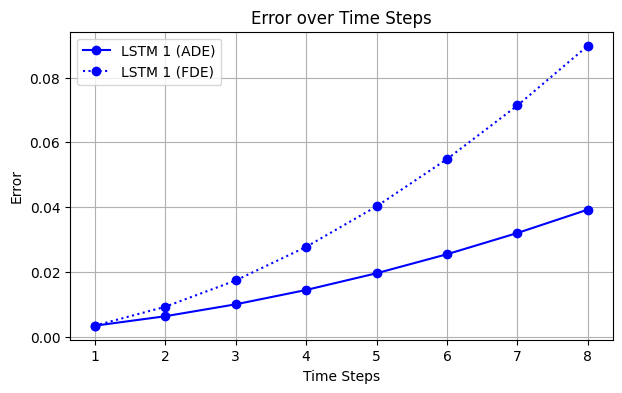

In [ ]:
# Set the figure size
plt.figure(figsize=(7, 4))

# Initialize ADE arrays
ade_per_step = np.zeros(8)
fde_per_step = np.zeros(8)
num_samples = val_observed.shape[0]

for i in range(1, 9):  # For time steps 1 to 8
    ade_this_step = ADE(val_future[:, :i, :], predicted_val_future[:, :i, :])
    fde_this_step = FDE(val_future[:, i-1, :], predicted_val_future[:, i-1, :])
    ade_per_step[i-1] = ade_this_step.numpy()  # Convert tensor to numpy
    fde_per_step[i-1] = fde_this_step.numpy()

# Plot the results
plt.plot(np.arange(1, 9), ade_per_step, marker='o', linestyle='-', color='blue', label='LSTM 1 (ADE)')
plt.plot(np.arange(1, 9), fde_per_step, marker='o', linestyle='dotted', color='blue', label='LSTM 1 (FDE)')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.title('Error over Time Steps')
plt.grid(True)
plt.legend()
plt.show()

The graph displays the error metrics of the first LSTM model over 8 time steps. The Average Displacement Error (ADE) gradually rises, indicating less accuracy for distant predictions. The Final Displacement Error (FDE) starts higher and increases faster, showing a more significant error in the model's ending predictions. Essentially, the model's accuracy decreases as it predicts further into the future.






**Display Sampled Trajectories**

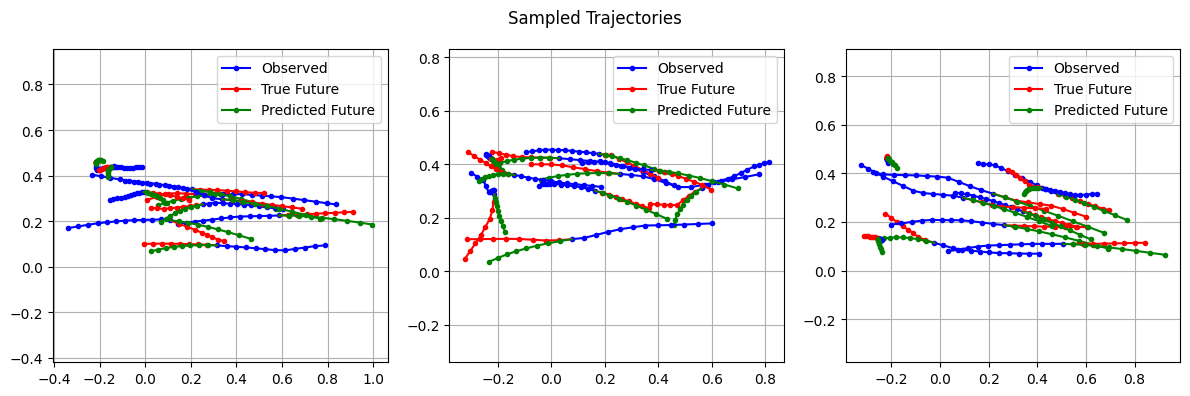

In [ ]:
# Display sampled trajectories using function from above
display_sampled_trajectories(val_observed, val_future, predicted_val_future)

The plots above display observed, true future, and predicted trajectories of movement. The observed paths (in blue) are the known movements, the true future paths (in red) are the actual subsequent movements, and the predicted paths (in green) are the LSTM model's forecasts based on the observed data. While the LSTM predictions align with the true future in some instances, deviations are evident in others. This suggests that the LSTM model can capture certain movement patterns but has room for improvement in predicting long-term trajectories.

## 4. Second LSTM Model (Encoder Decoder)

The second LSTM model follows the encoder-decoder architecture.

In [ ]:
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(None, 2))
encoder = tf.keras.layers.LSTM(32, return_state=True)
encoder_outputs, forward_h, forward_c = encoder(encoder_inputs)
encoder_states = [forward_h, forward_c]

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(None, 2))
decoder_lstm = tf.keras.layers.LSTM(32, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(2)
decoder_outputs = decoder_dense(decoder_outputs)

# Model
encoder_decoder_model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

# Early stopping callback
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Add custom callback to the list
callbacks_list=[PrintEvery10Epochs(), early_stopping_val_loss]

# Existing model compilation and data
encoder_decoder_model.compile(loss=ADE, optimizer="adam")

# Training data adaptation for this model structure
X_train_decode = np.zeros_like(train_future)
X_val_decode = np.zeros_like(val_future)

# Train the model with verbose set to 0
history = encoder_decoder_model.fit([train_observed, X_train_decode], train_future, epochs=100,
                                    validation_data=([val_observed, X_val_decode], val_future),
                                    callbacks=callbacks_list, verbose=0)

Epoch 0: val_loss = 0.03711457550525665, loss = 0.08978516608476639
Epoch 10: val_loss = 0.025510191917419434, loss = 0.032303743064403534
Epoch 20: val_loss = 0.02234255149960518, loss = 0.029785212129354477
Epoch 30: val_loss = 0.02133221924304962, loss = 0.029307298362255096


This model architecture represents an Encoder-Decoder LSTM with 32 neurons in each LSTM layer for trajectory prediction. The encoder takes observed trajectory data with shape (None, 2) as input and processes it through a 32-unit LSTM layer to capture its internal context, represented by its hidden (forward_h) and cell (forward_c) states. This context is then passed as the initial state to the decoder, which has its own 32-unit LSTM layer and generates the future trajectory sequence, also with shape (None, 2). The model is compiled using a custom loss function, Average Displacement Error (ADE), and optimized with the Adam algorithm. During training, early stopping based on validation loss and a custom callback for printing information every 10 epochs are employed. The training data for the decoder is initialized as an array of zeros. Overall, the architecture is designed to capture the full context of observed trajectories before making any predictions about future paths. It has 9026 trainable parameters in total as shown in the model summary below.

In [ ]:
# Show the architecture
encoder_decoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 2)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 2)]            0         []                            
                                                                                                  
 lstm_2 (LSTM)               [(None, 32),                 4480      ['input_1[0][0]']             
                              (None, 32),                                                         
                              (None, 32)]                                                         
                                                                                              

**Learning Curve**

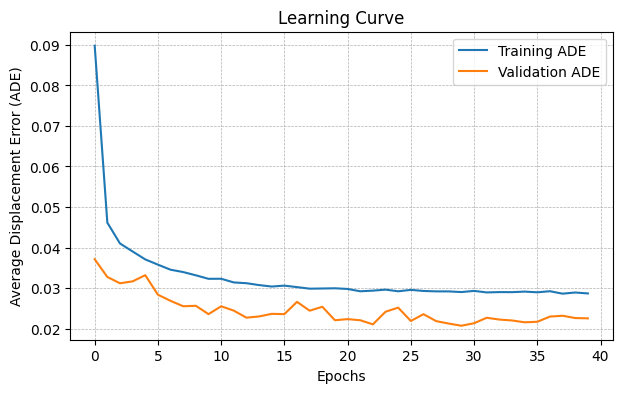

In [ ]:
# Plot learning curves using function from above
plot_learning_curves(history)


The learning curve displays the Average Displacement Error (ADE) of the Encoder-Decoder LSTM model over epochs for both training and validation datasets. Initially, there's a sharp decrease in errors for both sets. As epochs progress, the model converges, with both curves stabilizing after about 10 epochs. The small gap between the training and validation curves indicates a well-balanced model with minimal overfitting.

**Predict Remaining Frames**

In [ ]:
def predict_future_trajectory2(observed, model, future_len):
    predicted_future = np.zeros((observed.shape[0], future_len, 2))  # Initialize predicted_future array
    current_input = observed  # Initialize the input with the observed data
    decoder_input = np.zeros((observed.shape[0], 1, 2))  # Placeholder for the decoder input

    for i in range(future_len):
        next_step = model.predict([current_input, decoder_input], verbose=0)  # Model prediction for the next step
        predicted_future[:, i, :] = np.squeeze(next_step, axis=1)  # Store the prediction

        # Prepare the input for the next prediction
        current_input = np.concatenate([current_input[:, 1:, :], next_step], axis=1)

    return predicted_future

# Get the predicted future trajectory for the validation set
predicted_val_future2 = predict_future_trajectory2(val_observed, encoder_decoder_model, 8)

**Calculate Average Displacement Error (ADE) and Final Displacement Error (FDE)**


In [ ]:
# ADE & FDE using the predictions generated by the encoder-decoder model
ade_encoder_decoder = ADE(val_future, predicted_val_future2)
fde_encoder_decoder = FDE(val_future[:, -1, :], predicted_val_future2[:, -1, :])
print(f"Encoder-Decoder Model - Average Displacement Error (ADE): {ade_encoder_decoder:.4f}")
print(f"Encoder-Decoder Model - Final Displacement Error (FDE): {fde_encoder_decoder:.4f}")

Encoder-Decoder Model - Average Displacement Error (ADE): 0.0340
Encoder-Decoder Model - Final Displacement Error (FDE): 0.0769


**Display Sampled Trajectories**

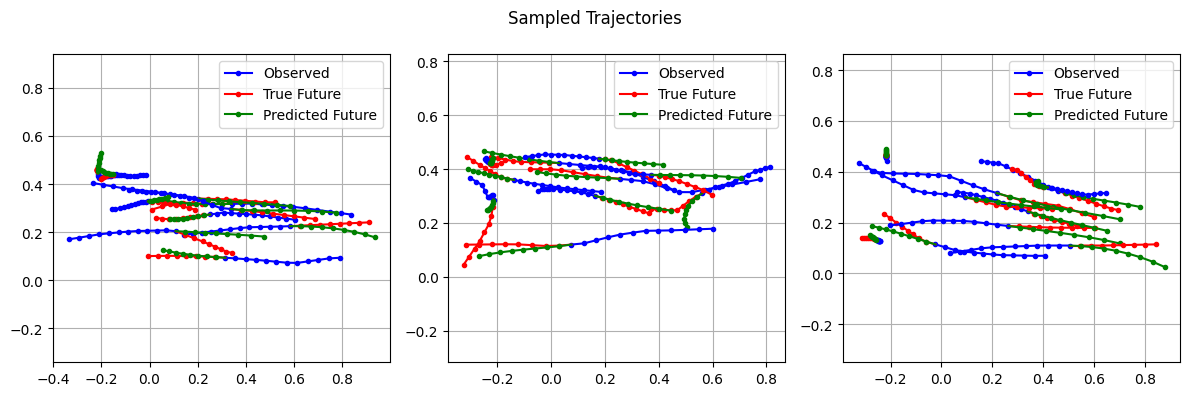

In [ ]:
# Display sampled trajectories using function from above
display_sampled_trajectories(val_observed, val_future, predicted_val_future2)

The plots above  displays sampled trajectories from the Encoder-Decoder LSTM model. The blue lines indicate observed paths, the red lines represent the actual future paths, and the green lines show the model's predictions. Overall, the Encoder-Decoder LSTM (LSTM 2) appears to provide reasonably accurate predictions, especially at the beginning of the trajectories. However, as the predictions extend further into the future, some deviations from the true future paths are observed. This behavior is expected in trajectory prediction, where predictions can become more uncertain as they extend further into the future.

**Plot Errors (ADE and FDE) vs Time Step**

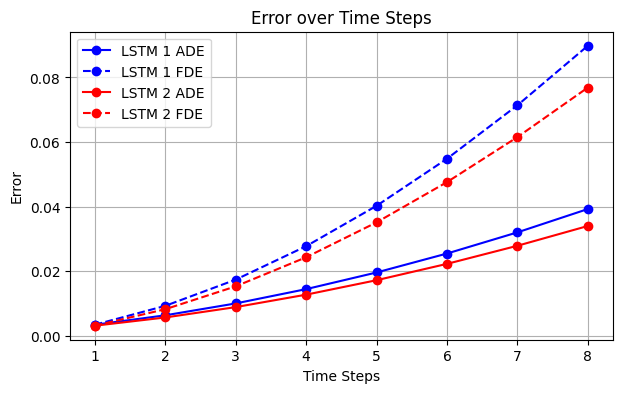

In [ ]:
# Set the figure size
plt.figure(figsize=(7, 4))

# Initialize ADE arrays
ade_per_step2 = np.zeros(8)
fde_per_step2 = np.zeros(8)
num_samples = val_observed.shape[0]

for i in range(1, 9):  # For time steps 1 to 8
    ade_this_step = ADE(val_future[:, :i, :], predicted_val_future2[:, :i, :])
    ade_per_step2[i-1] = ade_this_step.numpy()  # Convert tensor to numpy
    fde_this_step = FDE(val_future[:, i-1, :], predicted_val_future2[:, i-1, :])
    fde_per_step2[i-1] = fde_this_step.numpy()

# Plot the results
plt.plot(np.arange(1, 9), ade_per_step, marker='o', linestyle='-', color='blue', label='LSTM 1 ADE')
plt.plot(np.arange(1, 9), fde_per_step, marker='o', linestyle='--', color='blue', label='LSTM 1 FDE')
plt.plot(np.arange(1, 9), ade_per_step2, marker='o', linestyle='-', color='red', label='LSTM 2 ADE')
plt.plot(np.arange(1, 9), fde_per_step2, marker='o', linestyle='--', color='red', label='LSTM 2 FDE')
plt.xlabel('Time Steps')
plt.ylabel('Error')
plt.title('Error over Time Steps')
plt.grid(True)
plt.legend()
plt.show()

The plot compares the performance of two LSTM models (LSTM 1 and LSTM 2) over various time steps using Average Displacement Error (ADE) and Final Displacement Error (FDE) metrics. LSTM 2 (Encoder-Decoder) consistently demonstrates accuracy in its predictions, with both ADE and FDE values reflecting its capability. The Average Displacement Error (ADE) gradually rises, indicating less accuracy for distant predictions. The Final Displacement Error (FDE) starts higher and increases faster, showing a more significant error in the model's ending predictions. Essentially, the model's accuracy decreases as it predicts further into the future.

## 5. Comparisons of LSTM models

**1. ADE and FDE Performance:**

The plot above compares the performance of two LSTM models (LSTM 1 and LSTM 2) over various time steps using Average Displacement Error (ADE) and Final Displacement Error (FDE) metrics. **The Encoder-Decoder LSTM (LSTM 2) demonstrates better accuracy than the simpler LSTM model (LSTM 1)**, with both ADE and FDE being lower across all time steps, indicating that the encoder-decoder architecture provides more accurate trajectory predictions.

ADE (red solid line) rises with time steps but at a rate slower than LSTM 1, demonstrating improved accuracy over LSTM 1. FDE (red dashed line) mirrors the trend of ADE for LSTM 2, being consistently higher, but still outperforms LSTM 1 in terms of prediction accuracy for the final time step. The encoder-decoder architecture seems to handle the complexities of the data better than the simpler LSTM structure.

The Encoder-Decoder LSTM model outperforms the simpler LSTM model in trajectory prediction accuracy. Specifically, the Encoder-Decoder LSTM achieved an Average Displacement Error (ADE) of 0.0340 and a Final Displacement Error (FDE) of 0.0769. In contrast, the simpler LSTM model has an ADE of 0.0392 and an FDE of 0.0898. These numerical values underscore the higher accuracy of the Encoder-Decoder architecture in predicting future frames.

**2. Number of Parameters:**

The Encoder-Decoder LSTM model (LSTM 2) has more parameters (9,026) compared to the simpler LSTM model (LSTM 1) which has 7,650 parameters. The difference in the number of parameters is 1,376, with the Encoder-Decoder model having more due to its more complex architecture. Both models have all their parameters as trainable, and neither model has non-trainable parameters. LSTM 1 has fewer parameters, but the Encoder-Decoder LSTM 2, with more parameters, shows better performance. While having fewer parameters can lead to computational efficiency and reduced overfitting, a higher number of parameters can be beneficial for complex tasks and when there's ample training data. It's essential to balance model complexity with task requirements and available data.

**3. Analysis of LSTM Models with Varying Observed-to-Future Time Step**

Let's change the lengths of the observed and future parts to 10/10, 8/12, and 6/14 and compare how much the performances of both models drop with fewer observed timesteps and more future timesteps. We need to recompile and retrain the second LSTM model.

In [ ]:
# Train LSTM 2 model and make predictions on both LSTM 1 and LSTM 2
def train_evaluate_model(observed_len, future_len):

    # Split the trajectories based on the new lengths
    train_observed, train_future = split_trajectories(train_set, observed_len, future_len)
    val_observed, val_future = split_trajectories(val_set, observed_len, future_len)

    # LSTM 1
    predicted_val_future = predict_future_trajectory(val_observed, simple_model, future_len)

    # LSTM 2: Train and evaluate Encoder-Decoder Model
    encoder_decoder_model.compile(loss=ADE, optimizer="adam")
    X_train_decode = np.zeros_like(train_future)
    X_val_decode = np.zeros_like(val_future)
    history = encoder_decoder_model.fit([train_observed, X_train_decode], train_future, epochs=100,
                                    validation_data=([val_observed, X_val_decode], val_future),
                                    callbacks=early_stopping_val_loss, verbose=0)

    predicted_val_future2 = predict_future_trajectory2(val_observed, encoder_decoder_model, future_len)

    return predicted_val_future, predicted_val_future2

In [ ]:
# Calculate ADE, FDE and plot Errors vs Time Step
def calculate_and_plot_ade(val_future, predicted_val_future, predicted_val_future2, ax):
    # Ensure future_len is consistent with the shapes of predicted arrays
    future_len = min(val_future.shape[1], predicted_val_future.shape[1], predicted_val_future2.shape[1])

    # Initialize ADE arrays for LSTM 1
    ade_per_step = np.zeros(future_len)
    fde_per_step = np.zeros(future_len)
    for i in range(1, future_len + 1):
        ade_this_step = ADE(val_future[:, :i, :], predicted_val_future[:, :i, :])
        ade_per_step[i-1] = ade_this_step.numpy()
        fde_this_step = FDE(val_future[:, i-1, :], predicted_val_future[:, i-1, :])
        fde_per_step[i-1] = fde_this_step.numpy()

    # Initialize ADE and FDE arrays for LSTM 2 (Encoder-Decoder)
    ade_per_step2 = np.zeros(future_len)
    fde_per_step2 = np.zeros(future_len)
    for i in range(1, future_len + 1):
        ade_this_step = ADE(val_future[:, :i, :], predicted_val_future2[:, :i, :])
        ade_per_step2[i-1] = ade_this_step.numpy()
        fde_this_step = FDE(val_future[:, i-1, :], predicted_val_future2[:, i-1, :])
        fde_per_step2[i-1] = fde_this_step.numpy()

    # Plotting
    ax.plot(np.arange(1, future_len + 1), ade_per_step, marker='o', linestyle='-', color='blue', label='LSTM 1 ADE')
    ax.plot(np.arange(1, future_len + 1), fde_per_step, marker='o', linestyle='dotted', color='blue', label='LSTM 1 FDE')
    ax.plot(np.arange(1, future_len + 1), ade_per_step2, marker='o', linestyle='-', color='red', label='LSTM 2 ADE')
    ax.plot(np.arange(1, future_len + 1), fde_per_step2, marker='o', linestyle='dotted', color='red', label='LSTM 2 FDE')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Error')
    ax.set_title(f'ADE & FDE over Time Steps for future_len={future_len}')
    ax.grid(True)
    ax.legend()

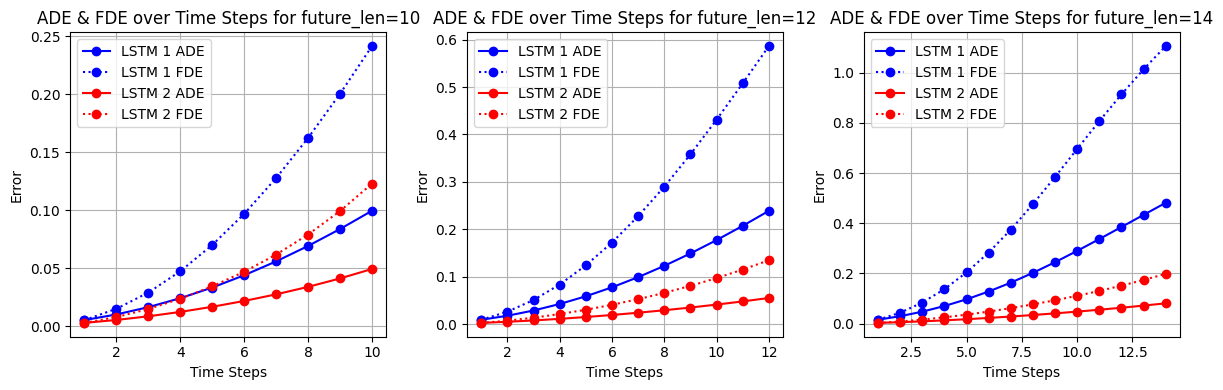

In [ ]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Different observed and future lengths
lengths = [(10, 10), (8, 12), (6, 14)]

# Call the functions
for idx, (observed_len, future_len) in enumerate(lengths):
    predicted_val_future, predicted_val_future2 = train_evaluate_model(observed_len, future_len)
    val_observed, val_future = split_trajectories(val_set, observed_len, future_len)
    calculate_and_plot_ade(val_future, predicted_val_future, predicted_val_future2, axs[idx])

plt.tight_layout()
plt.show()

- **10/10 Split** (Observed/Future Time Steps): For this even split between observed and future time steps, both LSTM models start with similar low error rates. However, as we progress through the time steps, LSTM 2 (Encoder-Decoder LSTM) maintains a consistently lower error rate for both ADE and FDE compared to LSTM 1. This showcases LSTM 2's superior ability to retain information and use it for more accurate predictions.

- **8/12 Split**: In this setup where the models have lesser observed data and more future data to predict, the distinction between the two models becomes even more pronounced. LSTM 2's error rates for both ADE and FDE are noticeably lower throughout. Especially in the later time steps, the difference in error between the two models widens, illustrating the strength of the Encoder-Decoder LSTM when dealing with a more challenging prediction task due to reduced observed data.

- **6/14 Split:** This represents the most challenging scenario with the least observed data and maximum future predictions. As expected, the errors for both models increase, reflecting the difficulty of the task. However, LSTM 2 outperforms LSTM 1 by a significant margin throughout. The gap between their errors is the widest in this scenario, emphasizing LSTM 2's robustness and capability to handle more complex prediction tasks even with limited observed data.

- The results from the experiment confirm that the Encoder-Decoder LSTM (LSTM 2) is better equipped to handle tasks with limited observed data and extended future predictions. Its consistent outperformance, especially when the observed-to-future ratio becomes more challenging, underscores its superior architecture and ability to handle data complexities. In real-world scenarios, where data can be limited, and long-term predictions are crucial, the Encoder-Decoder LSTM proves to be a more reliable choice.

Display Sampled Trajectories

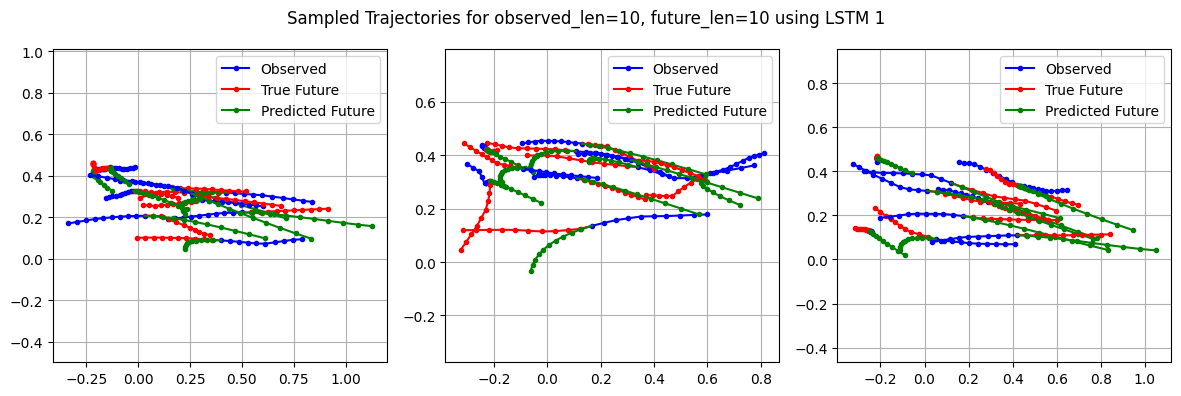

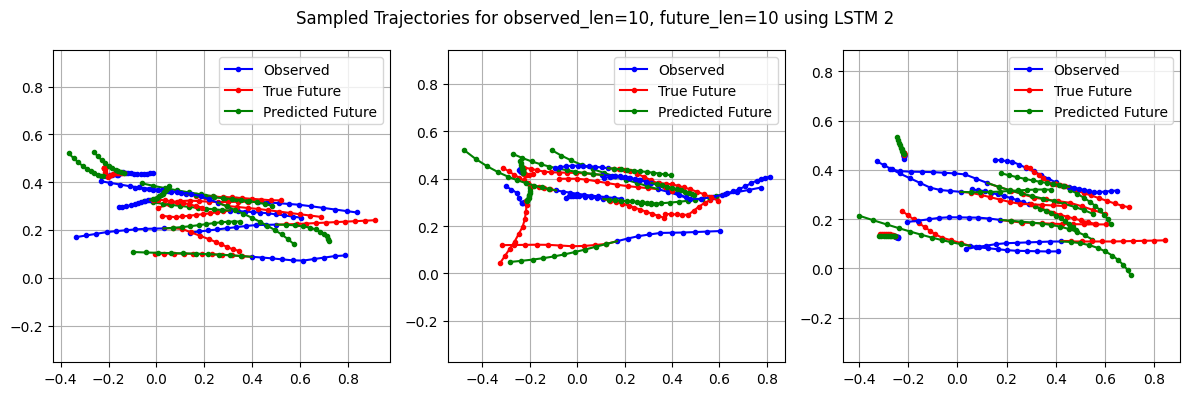

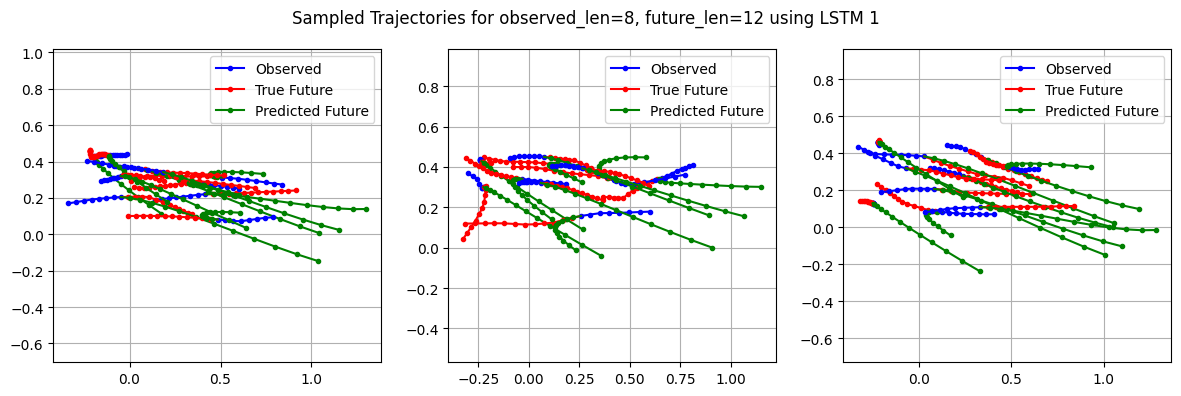

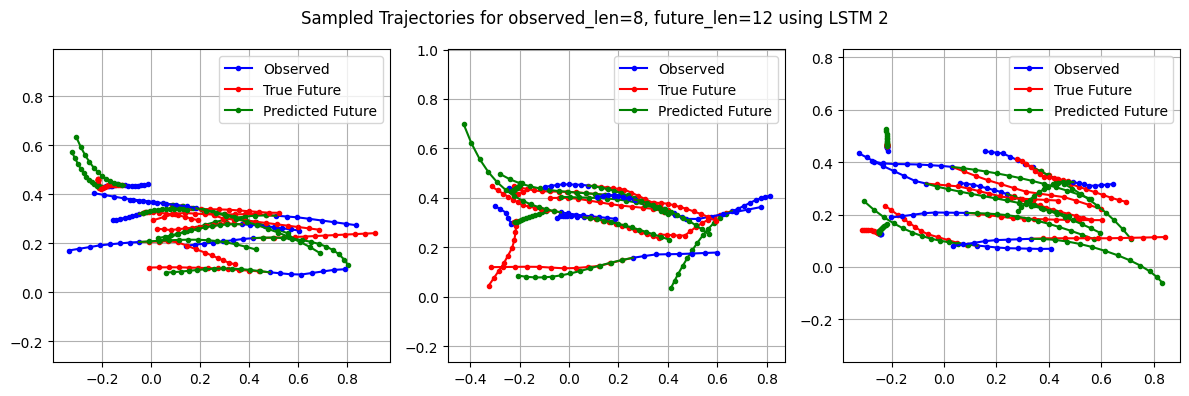

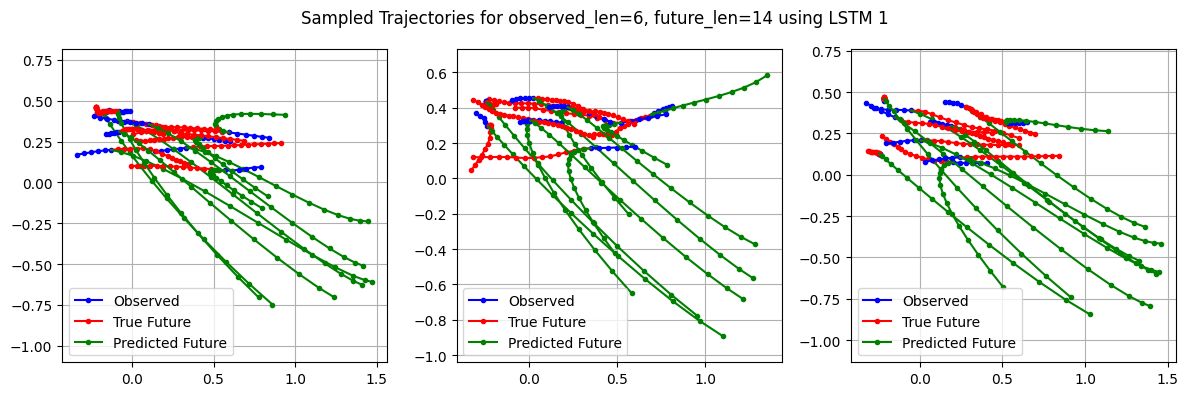

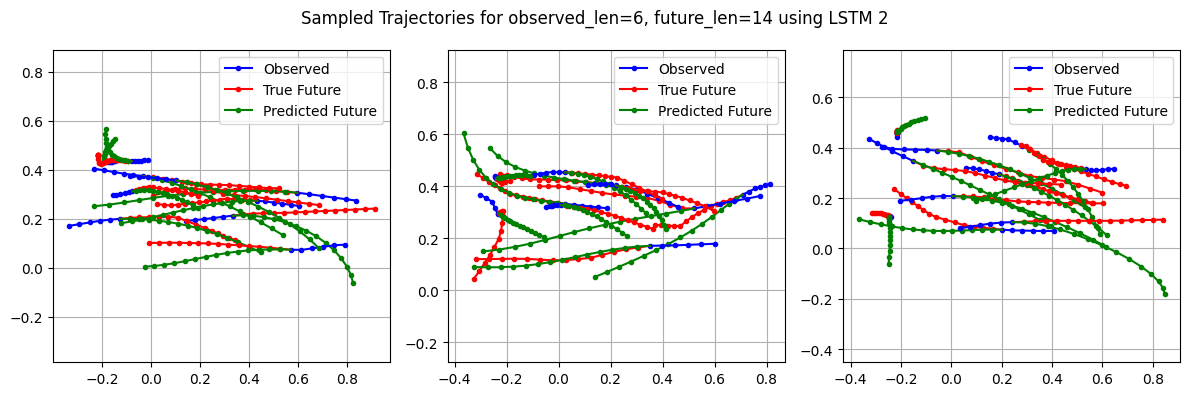

In [ ]:
# Loop through the combinations of observed_len and future_len
for observed_len, future_len in lengths:

    # Train and get the predictions
    predicted_val_future, predicted_val_future2 = train_evaluate_model(observed_len, future_len)

    # Get the val_observed and val_future
    val_observed, val_future = split_trajectories(val_set, observed_len, future_len)

    # Plot the trajectories using the first method
    title1 = f"Sampled Trajectories for observed_len={observed_len}, future_len={future_len} using LSTM 1"
    display_sampled_trajectories(val_observed, val_future, predicted_val_future, title=title1)

    # Plot the trajectories using the second method
    title2 = f"Sampled Trajectories for observed_len={observed_len}, future_len={future_len} using LSTM 2"
    display_sampled_trajectories(val_observed, val_future, predicted_val_future2, title=title2)


The plots above provide a visual understanding of the performance differences between LSTM 1 and LSTM 2 in predicting future trajectories for varying observed-to-future split. 6/14 split represents the most challenging scenario with the least observed data and maximum future predictions. Let's focus our explanation on the 6/14 split generated trajectories.

The predictions made by LSTM 1 vary across the plots. We observe that in many instances, the predicted trajectories deviate from the true future trajectories, especially as the time steps progress. This indicates that while LSTM 1 can capture the general direction of the motion, its predictions tend to diverge from the actual path over extended future time steps.

Comparing the predicted trajectories by LSTM 2 with the true future, we see a noticeable improvement over LSTM 1. While there are still deviations, LSTM 2's predictions are generally closer to the true future trajectories. In particular, the middle plot for LSTM 2 shows predictions that closely follow the actual trajectory, demonstrating its capability to predict more intricate patterns. However, it's evident that there are instances where LSTM 2 also faces challenges, particularly in predicting trajectories with sudden changes in direction.

## Trajectory Generation

Let's implement a variational autoencoder (VAE) that can generate trajectories of 20 frames long. Here, we use the training set to train our VAE model and the validation set for validation. The loss function includes the
reconstruction loss and the latent loss.

Epoch 0: val_loss = 0.252882719039917, loss = 0.27751660346984863
Epoch 10: val_loss = 0.1891031414270401, loss = 0.19642840325832367
Epoch 20: val_loss = 0.18635503947734833, loss = 0.19341334700584412
Epoch 30: val_loss = 0.18708811700344086, loss = 0.192177414894104
Epoch 40: val_loss = 0.18722300231456757, loss = 0.1908709555864334


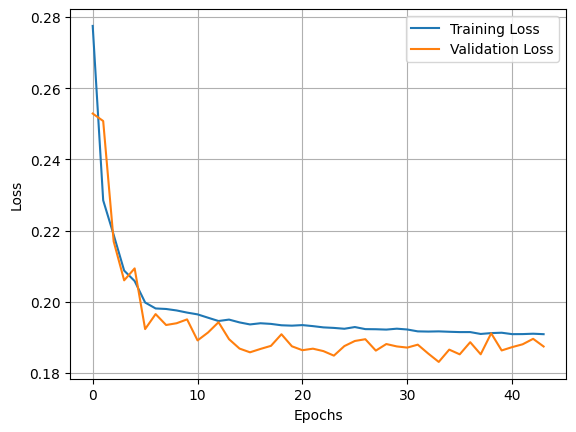

In [ ]:
# Define a customized sampling layer
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# The encoder part of the VAE
encoder_inputs = tf.keras.layers.Input(shape=(20, 2))
x = tf.keras.layers.LSTM(64, return_sequences=True)(encoder_inputs)
x = tf.keras.layers.LSTM(32)(x)
z_mean = tf.keras.layers.Dense(16)(x)
z_log_var = tf.keras.layers.Dense(16)(x)
z = Sampling()([z_mean, z_log_var])
variational_encoder = tf.keras.Model(inputs=[encoder_inputs], outputs=[z_mean, z_log_var, z])

# The decoder part of the VAE
decoder_inputs = tf.keras.layers.Input(shape=(16))  # 16 is the size of the latent space
x_decoded = tf.keras.layers.Dense(32, activation='relu')(decoder_inputs)
x_decoded = tf.keras.layers.RepeatVector(20)(x_decoded)
x_decoded = tf.keras.layers.LSTM(32, return_sequences=True)(x_decoded)
x_decoded = tf.keras.layers.LSTM(64, return_sequences=True)(x_decoded)
x_decoded_mean = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2))(x_decoded)

# Now join the encoder and decoder together to form our VAE
_, _, codings = variational_encoder(encoder_inputs)
reconstructions = tf.keras.Model(decoder_inputs, x_decoded_mean)(codings)
variational_ae = tf.keras.Model(inputs=[encoder_inputs], outputs=[reconstructions])

# Create the standalone decoder model immediately after defining the full VAE
decoder_model = tf.keras.Model(inputs=decoder_inputs, outputs=x_decoded_mean)

# Add the latent loss
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.exp(z_log_var) - tf.square(z_mean), axis=-1)
latent_loss = tf.reduce_mean(latent_loss) / 40  # 20 * 2 = 40, considering both time steps and features
variational_ae.add_loss(latent_loss)

# Early stopping
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Add custom callback to the list
callbacks_list=[PrintEvery10Epochs(), early_stopping_val_loss]

# Compile and train the VAE
variational_ae.compile(optimizer='adam', loss=ADE)

# Train the model
vae_history = variational_ae.fit(train_set, train_set, epochs=100, batch_size=32, validation_data=(val_set, val_set), callbacks=callbacks_list, verbose=0)

# Plot training and validation loss
plt.plot(vae_history.history['loss'], label='Training Loss')
plt.plot(vae_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The learning curve displayed visualizes the progression of training and validation loss over 30 epochs. The training loss, represented by the blue line, starts notably high but rapidly decreases, showing a steep drop within the first few epochs. By around epoch 5, it stabilizes and hovers around a loss value just under 0.20, indicating the model has learned a significant portion of the training data's structure by this point. On the other hand, the validation loss, depicted by the orange line, starts slightly lower than the training loss and also witnesses a sharp decline in the initial epochs. However, post this drop, the validation loss remains relatively stable, with minor fluctuations but generally staying between 0.18 and 0.20. The closeness in the values and trends of both training and validation losses suggests that the model is generalizing well to unseen data, without any clear signs of overfitting or underfitting.

In [ ]:
# Model architecture
variational_ae.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20, 2)]              0         []                            
                                                                                                  
 model_4 (Functional)        [(None, 16),                 30624     ['input_3[0][0]']             
                              (None, 16),                                                         
                              (None, 16)]                                                         
                                                                                                  
 model_5 (Functional)        (None, 20, 2)                33826     ['model_4[0][2]']             
                                                                                            

The model is a Variational Autoencoder (VAE) tailored for sequential data with an input shape of (20, 2). The encoder starts with two LSTM layers: the first with 64 units, which outputs sequences, and the second with 32 units. It then produces a mean and log variance, both of shape (16,) for the latent space representation. A custom sampling layer uses these to sample from the latent space. The decoder takes a (16,) input and uses a dense layer of 32 units followed by two LSTM layers: one with 32 units and another with 64 units, before outputting reconstructed sequences of shape (20, 2) through a time-distributed layer. During training, the model optimizes reconstruction with Average Displacement Error, accompanied by a latent loss. For efficiency, training employs callbacks, including early stopping based on validation loss. The model comprises a total of 64,450 parameters.

1/1 [==============================] - 0s 21ms/step


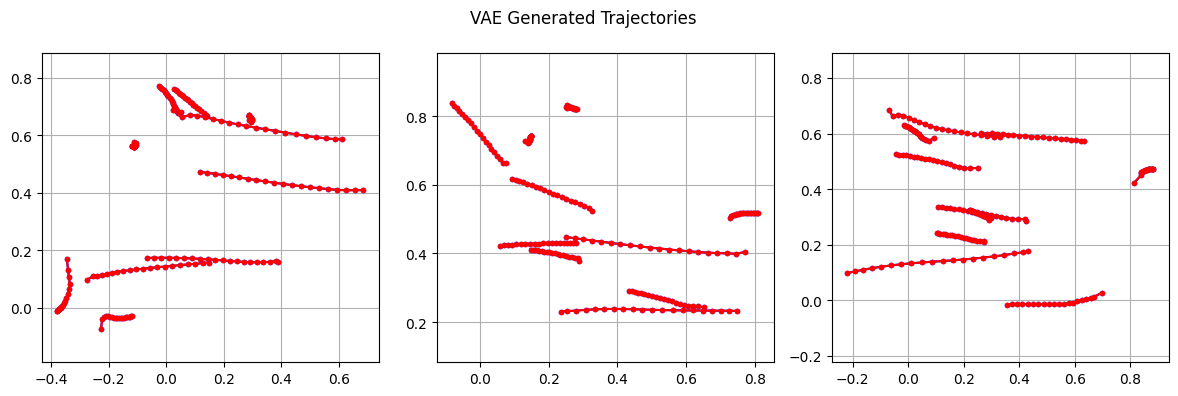

In [ ]:
# Generate new trajectories
n_samples = 30
random_latent_vectors = np.random.normal(size=(n_samples, 16))
generated_data = decoder_model.predict(random_latent_vectors)

# Display
display_sampled_trajectories(generated_data, generated_data, connect=False, title="VAE Generated Trajectories", show_legend=[False, False, False])

The plot showcases trajectories generated by a Variational Autoencoder (VAE). Across the three plots, the trajectories primarily appear continuous and maintain a consistent density, demonstrating the VAE's capability to model various trajectory patterns. Notably, while many trajectories span considerable lengths, we also observe some shorter, clustered trajectories. These short and densely clustered paths may suggest instances where pedestrians remained relatively stationary, potentially shifting or swaying slightly in position. Overall, the VAE seems to capture a wide range of behaviors from the latent space, effectively representing the underlying trajectory patterns. Nevertheless, further refinements could enhance its precision in modeling specific nuances.